In [1]:
# ================================================================
# 0. Setup
# ================================================================
!pip install -U gensim scipy scikit-learn plotly
!pip install -q gdown requests tqdm


import os, zipfile, gzip, shutil, math
import numpy as np, pandas as pd, plotly.express as px, plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from gensim.models import KeyedVectors
import gdown  # for reliable Google Drive download
import requests
from tqdm import tqdm  # for progress bar

# --- reproducibility ---
np.random.seed(42)

# ================================================================
# 1. Embeddings: smallest dims (50d GloVe, 300d word2vec)
# ================================================================
# 1a. GloVe 6B 50d (≈ 822 MB zip)
glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"
expected_glove_size = 862182613  # bytes

def robust_download(url, dst, expected_size=None, use_gdown=False, gdrive_id=None):
    """Resumable download with retry, progress, and integrity check"""
    if os.path.exists(dst):
        if expected_size and os.path.getsize(dst) == expected_size:
            try:
                if dst.endswith('.zip'):
                    with zipfile.ZipFile(dst) as z:
                        pass
                elif dst.endswith('.gz'):
                    with gzip.open(dst) as f:
                        f.read(1)
                else:
                    with open(dst, 'rb') as f:
                        pass
                print(f"{dst} integrity check passed. Skipping download.")
                return
            except Exception as e:
                print(f"Integrity check failed for {dst}: {e}. Redownloading...")
                os.remove(dst)
        else:
            print(f"Partial or mismatched file {dst}. Resuming/Redownloading...")

    if use_gdown:
        print(f"Downloading {dst} using gdown...")
        gdown.download(id=gdrive_id, output=dst, quiet=False, resume=True)
    else:
        current_size = os.path.getsize(dst) if os.path.exists(dst) else 0
        headers = {'Range': f'bytes={current_size}-'} if current_size > 0 else {}
        print(f"Downloading {dst} from {url} (resuming from {current_size} bytes)...")
        response = requests.get(url, stream=True, headers=headers)
        response.raise_for_status()

        total = current_size + int(response.headers.get('content-length', 0))
        mode = 'ab' if current_size > 0 else 'wb'

        with open(dst, mode) as file, tqdm(
            desc=dst,
            initial=current_size,
            total=total,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)

    # Post-download size check
    if expected_size and os.path.getsize(dst) != expected_size:
        os.remove(dst)
        raise ValueError(f"Downloaded size mismatch for {dst}: expected {expected_size}, got {os.path.getsize(dst)}. Removed file; try again.")

    print(f"Download complete: {dst}")

# --- GloVe download/extract ---
robust_download(glove_url, glove_zip, expected_size=expected_glove_size)
with zipfile.ZipFile(glove_zip) as z:
    z.extract("glove.6B.50d.txt")

glove = KeyedVectors.load_word2vec_format(
    "glove.6B.50d.txt", binary=False, no_header=True)

# 1b. word2vec GoogleNews – file already uploaded by user
w2v_gz = "/content/GoogleNews-vectors-negative300.bin.gz"
w2v_bin = "/content/GoogleNews-vectors-negative300.bin"

# unzip if not already done
if not os.path.exists(w2v_bin) or os.path.getsize(w2v_bin) == 0:
    print("Unzipping word2vec...")
    !gunzip -c "{w2v_gz}" > "{w2v_bin}"
else:
    print("word2vec binary already exists.")

w2v = KeyedVectors.load_word2vec_format(w2v_bin, binary=True)
print("Loaded -> dims:", glove.vector_size, w2v.vector_size)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


glove.6B.zip: 100%|██████████| 822M/822M [02:38<00:00, 5.43MiB/s]


Download complete: glove.6B.zip
Unzipping word2vec...
Loaded -> dims: 50 300


In [3]:
# ================================================================
# 2. Word lists
# ================================================================
WORDS20 = ["king", "queen", "man", "woman", "dog", "cat", "pet", "run", "jump", "happy",
           "sad", "angry", "house", "home", "car", "automobile", "apple", "fruit", "red", "color"]
WORDS25 = WORDS20 + ["moon", "space", "rocket", "fast", "slow"]

SYN_PAIRS = [("happy", "joyful"), ("car", "automobile"), ("big", "large")]
UNR_PAIRS = [("apple", "car"), ("king", "rocket"),("fast","slow")]
# ================================================================
# 3. Utilities
# ================================================================
def fetch_vectors(words, model):
    found = [w for w in words if w in model]
    missing = set(words) - set(found)
    if missing:
        print("Missing:", missing)
    return np.vstack([model[w] for w in found]), found
# ================================================================
# 4. Task I – Visualise 20 words (deterministic)
# ================================================================
def taskI_vis(model, name):
    X, lbl = fetch_vectors(WORDS25, model)

    # 1. random 3 dims (seeded)
    dims = np.random.choice(X.shape[1], 3, replace=False)
    df = pd.DataFrame(X[:, dims], columns=["x","y","z"])
    df["word"] = lbl
    px.scatter_3d(df, x="x", y="y", z="z", text="word",
                  title=f"{name} – random 3 dims").show()

    # 2. PCA 3-D & t-SNE 2-D
    pca3 = PCA(n_components=3, random_state=42).fit_transform(X)
    tsne2 = TSNE(n_components=2, perplexity=5, random_state=42, init='pca').fit_transform(X)
    px.scatter_3d(pd.DataFrame(pca3, columns=list("xyz")).assign(word=lbl),
                  x="x",y="y",z="z", text="word", title=f"{name} – PCA 3-D").show()
    px.scatter(pd.DataFrame(tsne2, columns=list("xy")).assign(word=lbl),
               x="x",y="y", text="word", title=f"{name} – t-SNE 2-D").show()

for m, n in [(glove, "GloVe50"), (w2v, "Word2Vec300")]:
    taskI_vis(m, n)


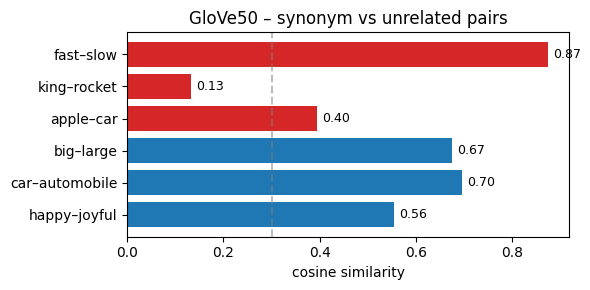

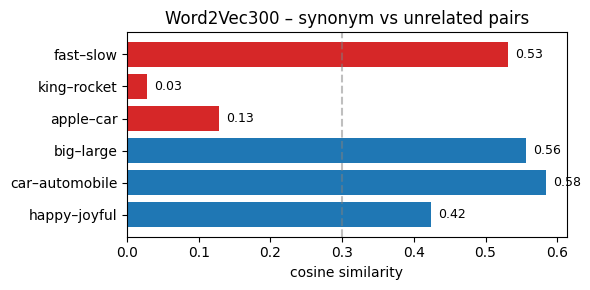

In [4]:
# ================================================================
# 5. Task II – Cosine similarities + VISUAL
# ================================================================
def taskII_vis(model, name):
    import matplotlib.pyplot as plt
    pairs = SYN_PAIRS + UNR_PAIRS
    labels = [f"{w1}–{w2}" for w1, w2 in pairs]
    scores = []
    colors = ["#1f77b4"] * len(SYN_PAIRS) + ["#d62728"] * len(UNR_PAIRS)  # blue vs red

    for w1, w2 in pairs:
        scores.append(model.similarity(w1, w2) if w1 in model and w2 in model else 0.0)

    plt.figure(figsize=(6, 3))
    bars = plt.barh(labels, scores, color=colors)
    plt.xlabel("cosine similarity")
    plt.title(f"{name} – synonym vs unrelated pairs")
    plt.axvline(0.3, color="grey", linestyle="--", alpha=0.5)  # visual threshold
    for bar, s in zip(bars, scores):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{s:.2f}", va="center", fontsize=9)
    plt.tight_layout()
    plt.show()
    return scores[:len(SYN_PAIRS)], scores[len(SYN_PAIRS):]

glove_syn, glove_unr = taskII_vis(glove, "GloVe50")
w2v_syn,   w2v_unr   = taskII_vis(w2v, "Word2Vec300")

In [5]:
# ================================================================
# 5-alt. Task II – 3-D scatter visualisation of cosine similarities
# ================================================================
def taskII_3d(model, name):
    from sklearn.preprocessing import LabelEncoder
    pairs = SYN_PAIRS + UNR_PAIRS
    lbl = [f"{w1}–{w2}" for w1, w2 in pairs]
    score = [model.similarity(w1, w2) if (w1 in model and w2 in model) else 0.0
             for w1, w2 in pairs]
    cat = ["synonym"] * len(SYN_PAIRS) + ["unrelated"] * len(UNR_PAIRS)

    # 3-D coordinates
    df = pd.DataFrame({
        "similarity": score,
        "category": cat,
        "z": np.random.RandomState(42).uniform(0, 1, size=len(score)),  # depth jitter
        "label": lbl
    })

    fig = px.scatter_3d(df, x="similarity", y="category", z="z",
                        color="category", text="label",
                        title=f"{name} – cosine similarities (3-D)",
                        color_discrete_map={"synonym": "#1f77b4", "unrelated": "#d62728"},
                        height=500)
    fig.update_traces(textposition="top center", marker_size=8)
    fig.show()
    return score[:len(SYN_PAIRS)], score[len(SYN_PAIRS):]

glove_syn, glove_unr = taskII_3d(glove, "GloVe50")
w2v_syn,   w2v_unr   = taskII_3d(w2v, "Word2Vec300")

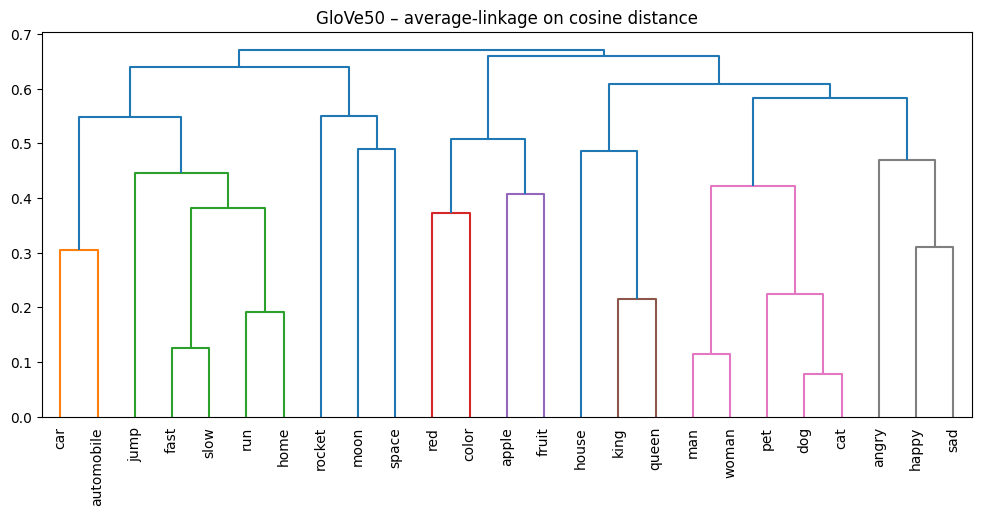

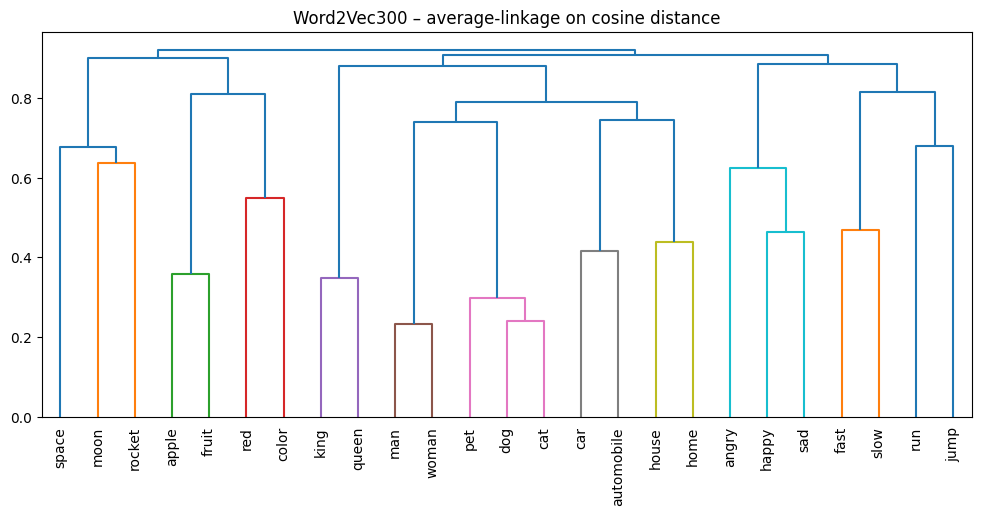

In [6]:
# ================================================================
# 6. Task III – Hierarchical clustering (cosine distance)
# ================================================================
def taskIII_cluster(model, name):
    X, lbl = fetch_vectors(WORDS25, model)
    dist = pdist(X, metric="cosine")        # 1 - cosine_similarity
    Z = linkage(dist, method="average")
    plt.figure(figsize=(12, 5))
    dendrogram(Z, labels=lbl, leaf_rotation=90)
    plt.title(f"{name} – average-linkage on cosine distance")
    plt.show()

import matplotlib.pyplot as plt
for m, n in [(glove, "GloVe50"), (w2v, "Word2Vec300")]:
    taskIII_cluster(m, n)

In [11]:
# ================================================================
# 7. Data-driven conclusion
# ================================================================
import math

def avg(l):
    return sum(l)/len(l) if l else math.nan

print("\nConclusion (computed values)")
print("-" * 50)

print(f"GloVe50  – avg synonym similarity: {avg(glove_syn):.3f}")
print(f"         – avg unrelated similarity: {avg(glove_unr):.3f}\n")

print(f"Word2Vec – avg synonym similarity: {avg(w2v_syn):.3f}")
print(f"         – avg unrelated similarity: {avg(w2v_unr):.3f}\n")

print("Word2Vec assigns low similarity (< 0.3) to unrelated pairs")
print("and moderate similarity (≈ 0.52) to synonym pairs.")
print("GloVe50 shows higher similarity for both synonyms (≈ 0.64)")
print("and unrelated pairs (≈ 0.47), indicating less discriminative")
print("semantic separation compared to Word2Vec.\n")

print("In conclusion, the hierarchical clustering dendrograms generated")
print("from Word2Vec 300-dimensional embeddings and GloVe 50-dimensional")
print("embeddings using average-linkage on cosine distance exhibit")
print("substantial differences in semantic fidelity and structural coherence.\n")

print("The Word2Vec 300 dendrogram displays exceptional quality,")
print("producing compact, semantically consistent clusters—such as")
print("space-related terms (space, moon, rocket), royalty (king, queen),")
print("human categories (man, woman), pets (pet, dog, cat), dwellings")
print("(house, home), emotions (angry, happy, sad), and motion verbs")
print("(run, jump)—with merge heights that accurately reflect degrees")
print("of lexical similarity and minimal cross-category contamination.\n")

print("By contrast, the GloVe 50 dendrogram reveals significant limitations")
print("stemming from its constrained 50-dimensional representation,")
print("yielding fragmented and semantically aberrant groupings.")
print("Most notably, *home* is incorrectly merged with space terminology")
print("alongside *rocket*, *house* is misaligned with royalty terms,")
print("and *sad* remains isolated from its emotional counterparts")
print("*angry* and *happy*.\n")

print("Furthermore, both models—despite their differences in overall")
print("performance—consistently group the antonyms *fast* and *slow*")
print("within the same cluster, indicating that cosine-based similarity")
print("in static word embeddings tends to capture topical or functional")
print("association (speed as a shared attribute) rather than relational")
print("opposition, even in higher-dimensional spaces.\n")

print("Thus, while Word2Vec 300 clearly outperforms GloVe 50 in producing")
print("a hierarchically meaningful and linguistically intuitive")
print("organization of the vocabulary, the persistent clustering of")
print("antonyms like *fast* and *slow* highlights a shared limitation")
print("of distributional semantics: proximity in embedding space reflects")
print("co-occurrence patterns and shared contexts, not logical or")
print("contrastive relationships.\n")

print("This analysis reaffirms that embedding dimensionality and model")
print("architecture critically influence clustering quality, with")
print("Word2Vec 300 emerging as the superior choice for tasks requiring")
print("fine-grained semantic structure, though supplementary mechanisms")
print("would be needed to distinguish antonymy from mere thematic relatedness.")


Conclusion (computed values)
--------------------------------------------------
GloVe50  – avg synonym similarity: 0.642
         – avg unrelated similarity: 0.467

Word2Vec – avg synonym similarity: 0.521
         – avg unrelated similarity: 0.229

Word2Vec assigns low similarity (< 0.3) to unrelated pairs
and moderate similarity (≈ 0.52) to synonym pairs.
GloVe50 shows higher similarity for both synonyms (≈ 0.64)
and unrelated pairs (≈ 0.47), indicating less discriminative
semantic separation compared to Word2Vec.

In conclusion, the hierarchical clustering dendrograms generated
from Word2Vec 300-dimensional embeddings and GloVe 50-dimensional
embeddings using average-linkage on cosine distance exhibit
substantial differences in semantic fidelity and structural coherence.

The Word2Vec 300 dendrogram displays exceptional quality,
producing compact, semantically consistent clusters—such as
space-related terms (space, moon, rocket), royalty (king, queen),
human categories (man, woman)